In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from gensim.corpora import Dictionary
import string
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import LSTM
from sklearn.metrics import roc_auc_score
import boto3

2024-01-20 21:39:49.772186: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-20 21:39:50.481706: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-20 21:39:50.711636: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-20 21:39:50.711656: I tensorflow/stream_executor/cuda/cuda

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
s3 = boto3.client('s3')
response = s3.list_buckets()

In [4]:
response

{'ResponseMetadata': {'RequestId': 'HW873NRXRFK6XAXY',
  'HostId': 'CBz5x06d6Y5OuOjjshWYCGHN2+sdmgeihL9lNxGv19rnPZ/pR7rIUvtxYbpguh6z9p7tkvgAPPU=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'CBz5x06d6Y5OuOjjshWYCGHN2+sdmgeihL9lNxGv19rnPZ/pR7rIUvtxYbpguh6z9p7tkvgAPPU=',
   'x-amz-request-id': 'HW873NRXRFK6XAXY',
   'date': 'Sat, 20 Jan 2024 19:51:40 GMT',
   'content-type': 'application/xml',
   'transfer-encoding': 'chunked',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'Buckets': [{'Name': 'aws-glue-assets-000104845890-us-east-1',
   'CreationDate': datetime.datetime(2024, 1, 17, 9, 50, 30, tzinfo=tzlocal())},
  {'Name': 'aws-logs-000104845890-us-east-1',
   'CreationDate': datetime.datetime(2024, 1, 17, 17, 53, 43, tzinfo=tzlocal())},
  {'Name': 'bucket-athena-results-17012024',
   'CreationDate': datetime.datetime(2024, 1, 17, 17, 27, 17, tzinfo=tzlocal())},
  {'Name': 'bucket-flink-18012024',
   'CreationDate': datetime.datetime(2024, 1, 18, 20, 16, 10, tzinfo=tz

In [5]:
s3 = boto3.resource('s3')
obj = s3.Object(bucket_name='bucket-raw-data16012024', key='part-01.json')
response = obj.get()
data = response['Body'].read()

In [6]:
json_test = json.loads(data)

In [7]:
df_pd = pd.DataFrame(json_test)

In [8]:
df_pd

,review_id,reviewer,movie,rating,review_summary,review_date,spoiler_tag,review_detail,helpful
0,rw5704482,raeldor-96879,After Life (2019– ),9,Very Strong Season 2,3 May 2020,0,"I enjoyed the first season, but I must say I t...","[1, 1]"
1,rw5704483,dosleeb,The Valhalla Murders (2019– ),6,Icelandic detectives?,3 May 2020,0,I know Iceland is a small country and police d...,"[2, 2]"
2,rw5704484,brightconscious,Special OPS (2020– ),7,Nothing special,3 May 2020,0,"Except K K , no other actor looks comfortable ...","[0, 0]"
3,rw5704485,gasconyway,#BlackAF (2020– ),8,Good but,3 May 2020,0,I'm guessing that as a 62 year old white woman...,"[5, 9]"
4,rw5704487,mmason-15867,The Droving (2020),2,An honest review,3 May 2020,0,Here's the truth. There's not much to this mov...,"[26, 41]"
...,...,...,...,...,...,...,...,...,...
1010288,rw0982994,backseat-2,Flight of the Phoenix (2004),3,What a waste,21 December 2004,1,The original Flight of the Phoenix is a classi...,"[16, 31]"
1010289,rw0982996,Sunshine95,A Series of Unfortunate Events (2004),10,Lots of Comedy,21 December 2004,1,Lemony Snickets was a Great movie because of t...,"[2, 3]"
1010290,rw0982997,ComeAsYouAre91,The Matrix (1999),8,Why Hate It???,21 December 2004,0,When The Matrix came out I was only twelve yea...,"[1, 3]"
1010291,rw0982998,skyymelonpeace44-1,Elf (2003),8,Best Christmas movie for kids,21 December 2004,0,I think the movie was really good.Its a kids m...,"[1, 4]"


In [9]:
df_pd.dtypes

review_id         object
reviewer          object
movie             object
rating            object
review_summary    object
review_date       object
spoiler_tag        int64
review_detail     object
helpful           object
dtype: object

In [10]:
df_pd.isna().sum()

review_id             0
reviewer              0
movie                 0
rating            51520
review_summary        0
review_date           0
spoiler_tag           0
review_detail         0
helpful               0
dtype: int64

In [33]:
df_pd1 = df_pd.copy()
df_pd1['rating'] = df_pd['rating'].fillna(np.nan).astype('float64')
df_pd1['helpful_0'] = df_pd['helpful'].apply(lambda x: x[0]).str.replace(",","").astype('int64')
df_pd1['helpful_1'] = df_pd['helpful'].apply(lambda x: x[1]).str.replace(",","").astype('int64')
df_pd1['helpful_perc'] = df_pd1['helpful_0']/df_pd1['helpful_1']
df_pd1['review_dt'] = pd.to_datetime(df_pd['review_date'],format="%d %B %Y")
df_pd1['review_year'] = df_pd1['review_dt'].dt.to_period('Y')
df_pd1['review_month'] = df_pd1['review_dt'].dt.to_period('M')
df_pd1['movie_year'] = df_pd['movie'].str.extract(r"\((\d+[^\)]*)\)[^\(]*$",expand=False).str.extract(r"(\d+)",expand=False).astype('float64')

In [34]:
df_pd1.head()

,review_id,reviewer,movie,rating,review_summary,review_date,spoiler_tag,review_detail,helpful,helpful_0,helpful_1,helpful_perc,review_dt,review_year,review_month,movie_year
0,rw5704482,raeldor-96879,After Life (2019– ),9.0,Very Strong Season 2,3 May 2020,0,"I enjoyed the first season, but I must say I t...","[1, 1]",1,1,1.000000,2020-05-03,2020,2020-05,2019.0
1,rw5704483,dosleeb,The Valhalla Murders (2019– ),6.0,Icelandic detectives?,3 May 2020,0,I know Iceland is a small country and police d...,"[2, 2]",2,2,1.000000,2020-05-03,2020,2020-05,2019.0
2,rw5704484,brightconscious,Special OPS (2020– ),7.0,Nothing special,3 May 2020,0,"Except K K , no other actor looks comfortable ...","[0, 0]",0,0,NaN,2020-05-03,2020,2020-05,2020.0
3,rw5704485,gasconyway,#BlackAF (2020– ),8.0,Good but,3 May 2020,0,I'm guessing that as a 62 year old white woman...,"[5, 9]",5,9,0.555556,2020-05-03,2020,2020-05,2020.0
4,rw5704487,mmason-15867,The Droving (2020),2.0,An honest review,3 May 2020,0,Here's the truth. There's not much to this mov...,"[26, 41]",26,41,0.634146,2020-05-03,2020,2020-05,2020.0


In [13]:
df_pd1.dtypes

review_id                 object
reviewer                  object
movie                     object
rating                   float64
review_summary            object
review_date               object
spoiler_tag                int64
review_detail             object
helpful                   object
helpful_0                  int64
helpful_1                  int64
helpful_perc             float64
review_dt         datetime64[ns]
movie_year               float64
dtype: object

In [14]:
# 1 najczesciej komentujacy
# 2 najczesciej oceniane filmy
# 3 rozklad ocen
# 4 najlepiej oceniane filmy
# 5 dlugosc review_summary
# 6 dlugosc review detail
# 7 rozklad review date
# 8 rok filmu a review date (popularnosc w czasie)
# 9 rozklady helpful_0, helpful_1, helpful_perc
# 10 helpful_perc a rating
# 11 spoiler_tag a rating
# 12 spoiler_tag a helpful_0, helpful_perc

### Użytkownicy mający najwięcej recenzji - top 10

In [15]:
reviewer_cnt = df_pd1.groupby('reviewer').size()

reviewer_cnt.sort_values(ascending=False).head(10)

reviewer
SnoopyStyle             4239
MartinHafer             3467
lor_                    2609
bkoganbing              2435
Horst_In_Translation    2381
Kirpianuscus            2259
Leofwine_draca          2205
boblipton               2193
TheLittleSongbird       2180
Prismark10              2159
dtype: int64

### Statystyki liczby recenzji na użytkownika

In [16]:
reviewer_cnt.describe(percentiles=[0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99])

count    419066.000000
mean          2.410821
std          19.240279
min           1.000000
1%            1.000000
5%            1.000000
10%           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
90%           3.000000
95%           5.000000
99%          19.000000
max        4239.000000
dtype: float64

### Najczęściej oceniane filmy

In [17]:
movie_cnt = df_pd1.groupby('movie').size()

movie_cnt.sort_values(ascending=False).head(10)

movie
Dil Bechara (2020)                                     7633
Wonder Woman 1984 (2020)                               6810
小丑 (2019)                                              6363
STAR WARS：天行者的崛起 (2019)                                5147
Laxmii (2020)                                          4748
Gunjan Saxena: The Kargil Girl (2020)                  4336
Supernatural: Carry On (2020) Season 15, Episode 20    3624
Coolie No. 1 (2020)                                    3319
Tenet (2020)                                           3122
Scam 1992: The Harshad Mehta Story (2020)              3044
dtype: int64

### Najlepiej oceniane filmy

Liczymy następującą miarę (podobną do stosowanej na Filmwebie):

$W = \frac{n}{n+100} R + \frac{100}{n+100} \bar{R},$

gdzie:

* $W$ - ranking filmu,

* $n$ - liczba ocen,

* $R$ - średnia ocena danego filmu,

* $\bar{R}$ - średnia ocen ze wszystkich recenzji.

Dzięki policzeniu powyższej miary w ten sposób odsiejemy filmy ocenione przez niewielką liczbę osób.

In [18]:
n_rev_movie = df_pd1.groupby('movie').size().reset_index().rename({0:'n'}, axis = 1)
mean_rating = df_pd1['rating'].mean()
mean_rating_movie = df_pd1.groupby('movie')['rating'].mean().reset_index()
df_W0 = mean_rating_movie.merge(n_rev_movie,how='left',on='movie')
df_W0['W'] = df_W0['n']/(df_W0['n'] + 100) * df_W0['rating'] + 100/(df_W0['n'] + 100) * mean_rating

df_W0.sort_values('W',ascending=False).head(10).rename({'rating':'mean_rating'},axis=1)

,movie,mean_rating,n,W
104051,Scam 1992: The Harshad Mehta Story (2020),9.818421,3044,9.719364
123117,The Chosen (2017– ),9.928154,1208,9.681663
34447,Dil Bechara (2020),9.720147,7633,9.681144
148739,Uncle Tom (2020),9.823797,1131,9.570365
11296,Atkan Chatkan (2020),9.885621,613,9.439398
110256,Soorarai Pottru (2020),9.599069,1510,9.419254
132492,The Mandalorian: Chapter 16: The Rescue (2020)...,9.616939,1053,9.364304
26955,Comedy Couple (2020),9.800659,607,9.362666
144927,Tiki Taka (2020),9.877670,515,9.361634
30465,Dark 7 White (2020– ),9.728183,701,9.350639


### Rozkład ocen

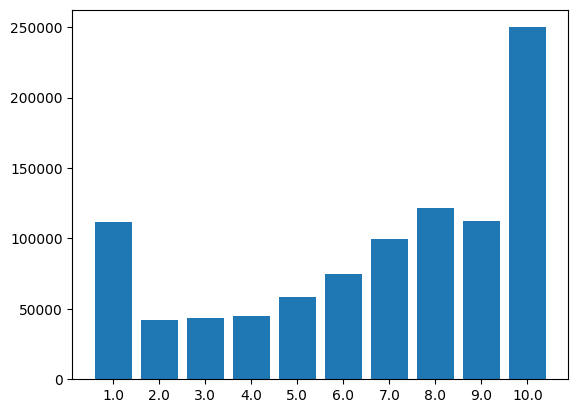

In [32]:
n_ratings = df_pd1.groupby('rating').size().reset_index().rename({0:'n'},axis=1)
plt.bar(n_ratings['rating'].astype('string'),n_ratings['n'])
plt.show()

### Rozkład długości podsumowania recenzji (wg liczby słów)

In [24]:
review_summary_len = df_pd1['review_summary'].apply(lambda x: len(x.split()))
review_summary_len.describe()

count    1.010293e+06
mean     5.121441e+00
std      3.664155e+00
min      0.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      7.000000e+00
max      5.700000e+02
Name: review_summary, dtype: float64

### Histogram dla długości podsumowania recenzji

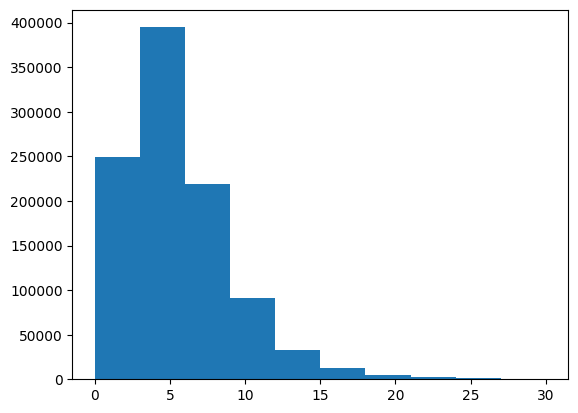

In [31]:
plt.hist(review_summary_len,range=(0,30))
plt.show()

### Rozkład długości recenzji (wg liczby słów)

In [23]:
review_len = df_pd1['review_detail'].apply(lambda x: len(x.split()))
review_len.describe()

count    1.010293e+06
mean     1.456024e+02
std      1.687053e+02
min      1.000000e+00
25%      3.600000e+01
50%      9.400000e+01
75%      1.830000e+02
max      3.339000e+03
Name: review_detail, dtype: float64

### Histogram dla długości recenzji

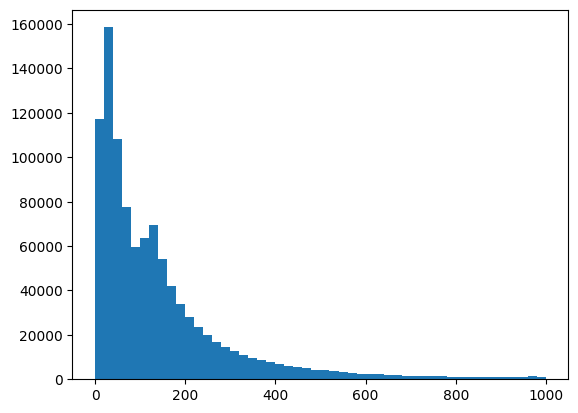

In [30]:
plt.hist(review_len,range=(0,1000),bins=50)
plt.show()

### Helpful_0 - rozkład

In [38]:
df_pd1['helpful_0'].describe()

count    1.010293e+06
mean     5.795557e+00
std      2.906494e+01
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      4.000000e+00
max      6.201000e+03
Name: helpful_0, dtype: float64

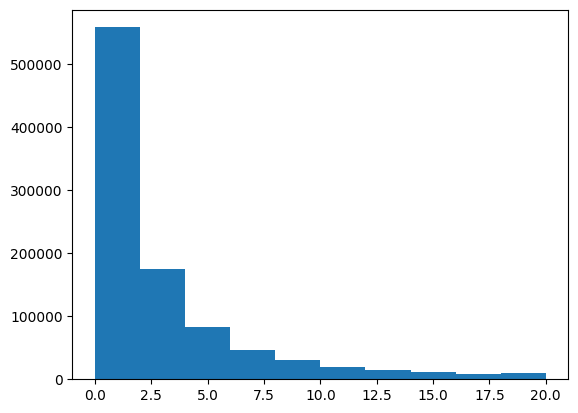

In [44]:
plt.hist(df_pd1['helpful_0'],range=(0,20))
plt.show()

### Helpful_1 - rozkład

In [45]:
df_pd1['helpful_1'].describe()

count    1.010293e+06
mean     1.074100e+01
std      4.506193e+01
min      0.000000e+00
25%      1.000000e+00
50%      3.000000e+00
75%      8.000000e+00
max      8.771000e+03
Name: helpful_1, dtype: float64

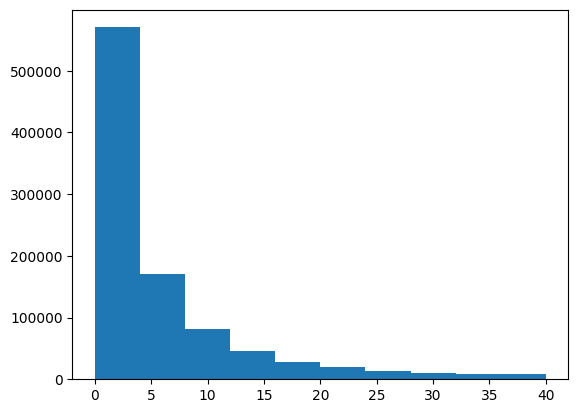

In [46]:
plt.hist(df_pd1['helpful_1'],range=(0,40))
plt.show()

### Rozkład helpful_perc

In [47]:
df_pd1['helpful_perc'].describe()

count    764498.000000
mean          0.516735
std           0.329960
min           0.000000
25%           0.285714
50%           0.500000
75%           0.758386
max           1.000000
Name: helpful_perc, dtype: float64

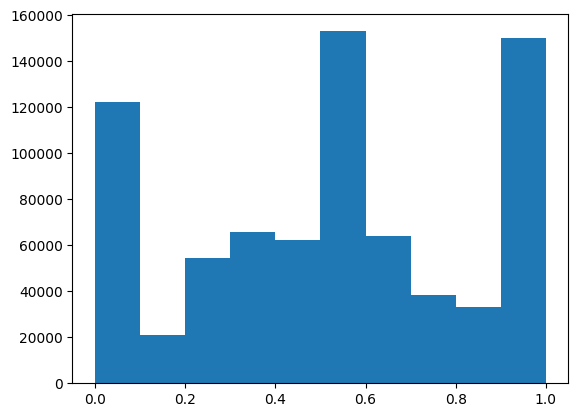

In [48]:
plt.hist(df_pd1['helpful_perc'])
plt.show()

### Rozkład helpful_perc tam, gdzie helpful_1>=med(helpful_1)=3

In [53]:
w = df_pd1.loc[df_pd1['helpful_1']>=3,:]['helpful_perc']
w.describe()

count    513872.000000
mean          0.506657
std           0.253232
min           0.000000
25%           0.333333
50%           0.500000
75%           0.666667
max           1.000000
Name: helpful_perc, dtype: float64

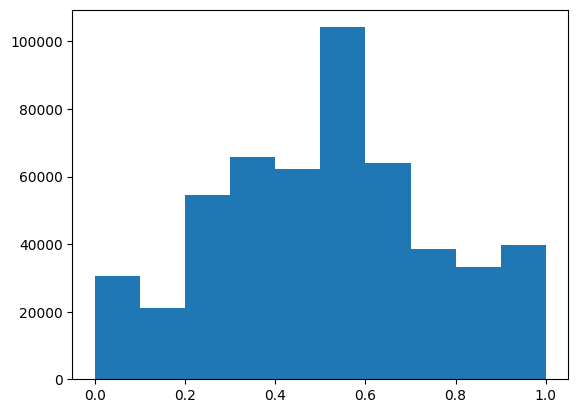

In [54]:
plt.hist(w)
plt.show()

### Rozkład helpful_perc a rating

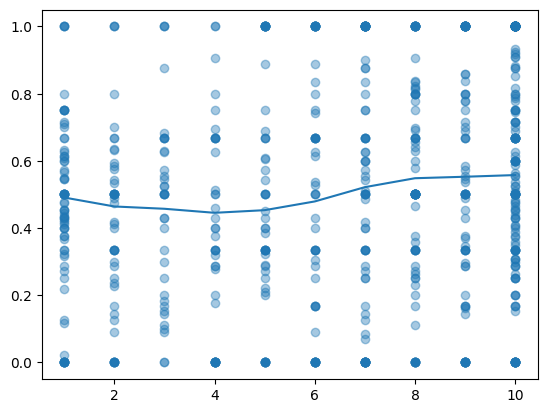

In [62]:
df_sample = df_pd1.sample(1000)

mean_helpful_perc_per_rating = df_pd1.groupby(['rating'])['helpful_perc'].mean().reset_index()

plt.scatter(df_sample['rating'],df_sample['helpful_perc'],alpha=0.4)
plt.plot(mean_helpful_perc_per_rating['rating'],mean_helpful_perc_per_rating['helpful_perc'])
plt.show()

### Spoiler tag a rating

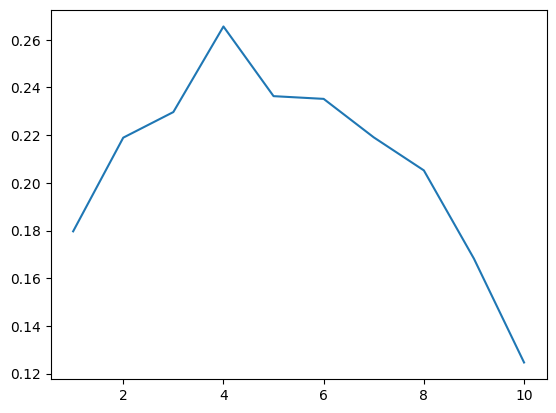

In [64]:
mean_spoiler_tag_per_rating = df_pd1.groupby(['rating'])['spoiler_tag'].mean().reset_index()
plt.plot(mean_spoiler_tag_per_rating['rating'],mean_spoiler_tag_per_rating['spoiler_tag'])
plt.show()

In [68]:
punc = string.punctuation

def wt(string):
    return [w.lower() for w in word_tokenize(string)
                if w.lower() not in punc]

review_detail_clear = df_pd1['review_detail'].apply(wt)
dct = Dictionary(review_detail_clear)


tokens_in_dataset = 5000
document_max_len = 400
batch_size = 32
embedding_dim = 64

In [69]:
review_detail_clear

0          [i, enjoyed, the, first, season, but, i, must,...
1          [i, know, iceland, is, a, small, country, and,...
2          [except, k, k, no, other, actor, looks, comfor...
3          [i, 'm, guessing, that, as, a, 62, year, old, ...
4          [here, 's, the, truth, there, 's, not, much, t...
                                 ...                        
1010288    [the, original, flight, of, the, phoenix, is, ...
1010289    [lemony, snickets, was, a, great, movie, becau...
1010290    [when, the, matrix, came, out, i, was, only, t...
1010291    [i, think, the, movie, was, really, good.its, ...
1010292    [my, mother, and, i, watch, house, religiously...
Name: review_detail, Length: 1010293, dtype: object

In [ ]:
# w ponizszym kroku kodujemy tokeny za pomoca slownika, a nastepnie
# liczymy hashe (w uproszczony sposob), by ograniczyc wielkosc slownika do
# embeddingu
review_detail_idx = review_detail_clear.apply(lambda x: [y%tokens_in_dataset 
                                                         for y in dct.doc2idx(x)])

target = np.array(df_pd['spoiler_tag'].copy())

x_train, x_test, y_train, y_test = train_test_split(review_detail_idx,
                                                    target, test_size = 0.3,
                                                    random_state=12)

(array([444., 260., 114.,  80.,  39.,  24.,  11.,  13.,   7.,   8.]),
 array([  87. ,  181.6,  276.2,  370.8,  465.4,  560. ,  654.6,  749.2,
         843.8,  938.4, 1033. ]),
 <BarContainer object of 10 artists>)

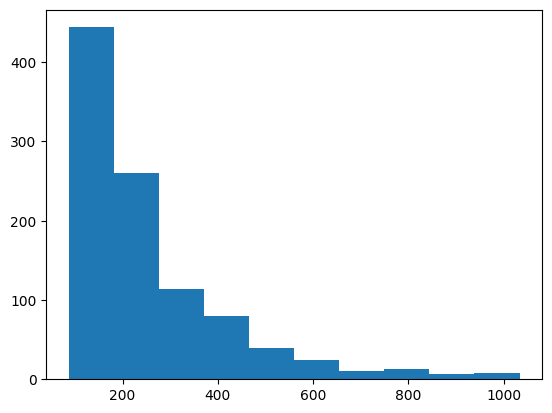

In [18]:
plt.hist([len(x_train.iloc[i]) for i in range(1000)])

In [19]:
x_train = sequence.pad_sequences(x_train, maxlen=document_max_len, padding='pre', truncating='post')
x_test = sequence.pad_sequences(x_test, maxlen=document_max_len, padding='pre', truncating='post')

In [20]:
model = Sequential()

model.add(Embedding(input_dim=tokens_in_dataset, # liczba unikalnych tokenów
                    output_dim=embedding_dim, # wielkość embeddingu
                    input_length=document_max_len, # długość sekwencji
                    ))
model.add(LSTM(units=32, activation='tanh', return_sequences=True))
model.add(LSTM(units=16, activation='tanh', return_sequences=False))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

es = EarlyStopping(patience=3, monitor='val_loss')
model.summary()

2024-01-16 15:46:06.349169: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-01-16 15:46:06.349219: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-01-16 15:46:06.349262: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-89-90): /proc/driver/nvidia/version does not exist
2024-01-16 15:46:06.349646: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 64)           320000    
                                                                 
 lstm (LSTM)                 (None, 400, 32)           12416     
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 335,841
Trainable params: 335,841
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.fit(x_train, y_train, batch_size=batch_size,
          callbacks=[es],
          validation_split=0.2,
          epochs=20)

Epoch 1/20


2024-01-16 15:46:23.406893: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 89600000 exceeds 10% of free system memory.


1750/1750 [==============================] - 480s 272ms/step - loss: 0.5288 - accuracy: 0.7737 - val_loss: 0.5025 - val_accuracy: 0.7743
Epoch 2/20
1750/1750 [==============================] - 477s 273ms/step - loss: 0.5133 - accuracy: 0.7747 - val_loss: 0.5259 - val_accuracy: 0.7743
Epoch 3/20
1750/1750 [==============================] - 471s 269ms/step - loss: 0.4855 - accuracy: 0.7779 - val_loss: 0.4881 - val_accuracy: 0.7774
Epoch 4/20
1750/1750 [==============================] - 474s 271ms/step - loss: 0.4474 - accuracy: 0.7974 - val_loss: 0.4780 - val_accuracy: 0.7889
Epoch 5/20
1750/1750 [==============================] - 476s 272ms/step - loss: 0.4187 - accuracy: 0.8119 - val_loss: 0.4955 - val_accuracy: 0.7689
Epoch 6/20
1750/1750 [==============================] - 476s 272ms/step - loss: 0.3889 - accuracy: 0.8274 - val_loss: 0.5067 - val_accuracy: 0.7769
Epoch 7/20
1750/1750 [==============================] - 476s 272ms/step - loss: 0.3638 - accuracy: 0.8411 - val_loss: 0.538

In [22]:
model.evaluate(x_test,y_test)

938/938 [==============================] - 63s 67ms/step - loss: 0.5337 - accuracy: 0.7559


[0.5337475538253784, 0.7559000253677368]

In [23]:
prob_pred_train = model.predict(x_train)
prob_pred_test = model.predict(x_test)
AUC = {
       'train': roc_auc_score(y_train,prob_pred_train),
       'test': roc_auc_score(y_test,prob_pred_test),
       }

print(AUC)

2024-01-16 16:44:13.820221: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 112000000 exceeds 10% of free system memory.


938/938 [==============================] - 62s 66ms/step
{'train': 0.871267179678177, 'test': 0.6941233042764144}
